### Explainable AI in Employee Attrition Prediction

- [View Solution Notebook](./solutions.html)
- [View Project Page](https://www.codecademy.com/content-items/707237fd8b054ff6b5873d92d61c361c)

  
Predicting employee attrition is challenging for HR departments, as it helps organizations retain valuable talent and reduce turnover costs. However, AI models used in such decisions must be transparent and interpretable, ensuring that HR professionals can trust and understand the predictions.

In this project, we will use the IBM HR Analytics Employee Attrition Dataset (https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset) to predict whether an employee will likely leave the company. We will train different machine learning models and apply Explainable AI (XAI) techniques to interpret their predictions.

In this project, you will:
* Understand how different models predict attrition and which factors matter most.
* Use XAI techniques to interpret different models, including model-specific and model-agnostic methods
* Utilize visualization tools, like PDP and ICE plots, to show how features influence predictions.

By the end of this project, we will have a fully interpretable pipeline that can help HR professionals make informed, fair, and data-driven decisions regarding employee retention.

**Setup - Import Libraries**

Run the cell below to import the libraries.

In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay

%matplotlib inline

## Task Group 1 - Load and Explore the Dataset

Let's first import the dataset and explore its structure, data types, missing values, and target distribution.

### Task 1
Load and prepare the attrition dataset:
* Load the dataset using pandas and the filename `attrition_data.csv.`
* Explore the dataset’s structure, including column names, data types, and the first few rows. Print the data frame head and info.
* Check for missing values to determine if any data cleaning is needed.
* Examine the distribution of the target variable (Attrition) to understand class balance. 

In [39]:
df = pd.read_csv("attrition_data.csv")
print(df.info())
print(df.head())
print(df.isnull().sum())

# Check target class distribution
print(df["Attrition"].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

This shows that only ~16% of employees left, meaning the dataset is fairly imbalanced.  No missing values are found, so you do not have to handle these.  However, there are categorical variables that will need encoding, and the numerical features will require scaling.


## Task Group 2 - Data Preprocessing


### Task 2
Convert the target variable to numerical format (Yes/No → 1/0)
- Machine learning models require numerical inputs, so categorical values in the target variable must be mapped to numbers.
- The Yes/No values in the "Attrition" column should be replaced with 1 (Yes - employee left) and 0 (No - employee stayed).


In [40]:
# Convert target variable (Attrition: Yes/No → 1/0)
df["Attrition"] = df["Attrition"].map({"Yes": 1, "No": 0})

### Task 3
Drop Non-Informative Columns
* Some columns do not contribute to prediction and should be removed to reduce noise and improve model performance.
* `EmployeeNumber` (Unique ID, irrelevant for predictions)
* `Over18` (All values are the same, no variability)
* `EmployeeCount` and `StandardHours` (Constant values, provide no useful information)

In [41]:
# Drop non-informative columns
df.drop(["EmployeeNumber", "Over18", "EmployeeCount", "StandardHours"], axis=1, inplace=True) # More memory efficient 
print(df.columns)


Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')


### Task 4
Convert Categorical Features into Numerical (pd.get_dummies)
* Many features in the dataset are categorical (e.g., `JobRole,` `BusinessTravel`).
* We need to convert them into a numerical format so that machine learning models can process them.
* One-hot encoding (`pd.get_dummies`) creates binary columns for each category.
* `drop_first=True` prevents redundant dummy variables (avoiding multicollinearity).

In [42]:
# Convert categorical features to numeric
categorical_cols = df.select_dtypes(include=["object"]).columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

### Task 5
Split the Data into Training and Test Sets
* Define `X` and `y` as your features and target.
* Split the data using `train_test_split` with `test_size=0.2.`
* Use `stratify=y` to ensure that both train and test sets maintain the original class distribution (important when dealing with imbalanced data).

In [43]:
# Split data into train-test sets
X = df.drop("Attrition", axis=1)
y = df["Attrition"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Task 6
Scale Numerical Features
* Some models (Logistic Regression, SVM, Neural Networks) perform better when numerical features are scaled.
* Standardization (`StandardScaler`) transforms numerical values to zero mean and unit variance.
* Fit `StandardScaler()` on `X_train` and transform `X_test` separately to prevent data leakage.
* Saved the rescaled features as `X_tran_scaled` and `X_test_scaled`

In [44]:
# Normalize numerical features
scaler = StandardScaler()
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns

X_train_scaled = X_train.copy(deep=True)
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled = X_test.copy(deep=True)
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

## Task Group 3 - Logistic Regression and Coefficients Interpretation
Now, you are ready to train your first model, logistic regression, and use the model's coefficients to explain the output.

### Task 7
Train a Logistic Regression Model 
* Define a logistic regression model using `max_iter=500` to ensure that the model has enough iterations to converge.
* Train the model using `.fit()` with `X_train_scaled` and `y_train.`

In [45]:
# Train Logistic Regression Model
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=500)

### Task 8
Extract Model Coefficients
* Extract the model coefficients and store them in a Pandas Series with index the features name
* Sort the values in the series

In [46]:
# Get feature importance (coefficients)
coefficients = pd.Series(log_reg.coef_[0], index=X.columns).sort_values()

### Task 9
Plot Feature Importance using a Bar Chart 
* Bar plots can help visualize which features strongly influence employee attrition.
* Features with high positive values contribute to higher attrition rates.
* Features with high negative values contribute to lower attrition rates (employees staying).
* Use `plt.barh()` and pass in the coefficients indices and values.

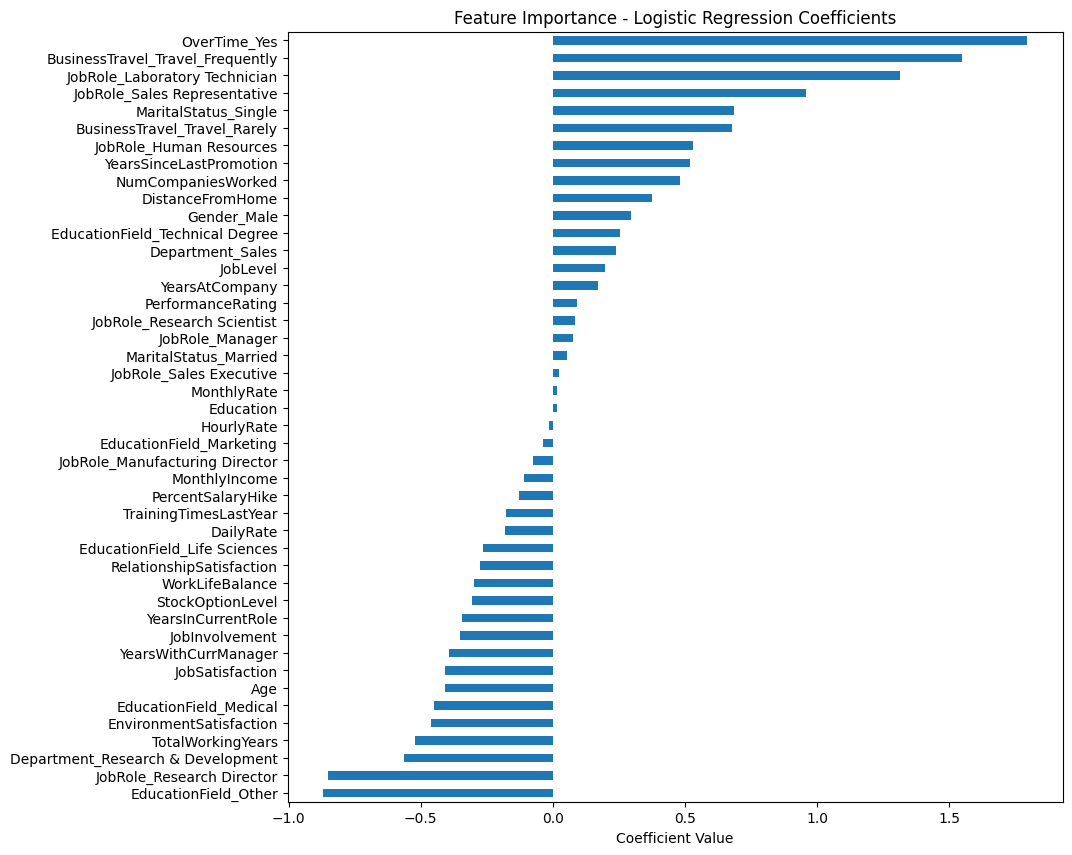

In [47]:
# Plot feature coefficients
plt.figure(figsize=(10,10))
coefficients.plot(kind="barh")
plt.title("Feature Importance - Logistic Regression Coefficients")
plt.xlabel("Coefficient Value")
plt.show()

After running this code, you should see a horizontal bar chart with feature names on the y-axis and their corresponding coefficient values on the x-axis.
* Features with high positive values (e.g., `OverTime`) increase the risk of attrition.
* Features with high negative values (e.g., `EducationField_Other`, `TotalWorkingYears`) decrease the risk of attrition (they encourage employees to stay).

## Task Group 4 - Permutation Importance

### Task 10
Compute Permutation Importance 
* Calculate the permutation importance for the logistic regression model.  Pass in the model, `X_test_scaled,` and `y_test.`
* Use `n_repeats=10` → Runs the permutation process 10 times for more stable results.
* Use `random_state=42` → Ensures reproducibility.

In [48]:
# Compute permutation importance
perm_importance = permutation_importance(log_reg, X_test_scaled, y_test, n_repeats=10, random_state=42)

### Task 11
Convert Results to a Pandas DataFrame
* The results from permutation_importance are stored in a dictionary
* Extract the mean importance score for each feature and store it in a DataFrame for better visualization and sorting.
* Sorting in descending order ensures that the most important features appear at the top.

In [49]:
# Convert to DataFrame
perm_df = pd.DataFrame({"Feature": X.columns, "Importance": perm_importance.importances_mean})
perm_df = perm_df.sort_values(by="Importance", ascending=False)


### Task 12
Plot Permutation Importance as a Bar Chart
* Plot the permutation importance as a horizontal bar chart with feature names and permutation importance values as the heights.

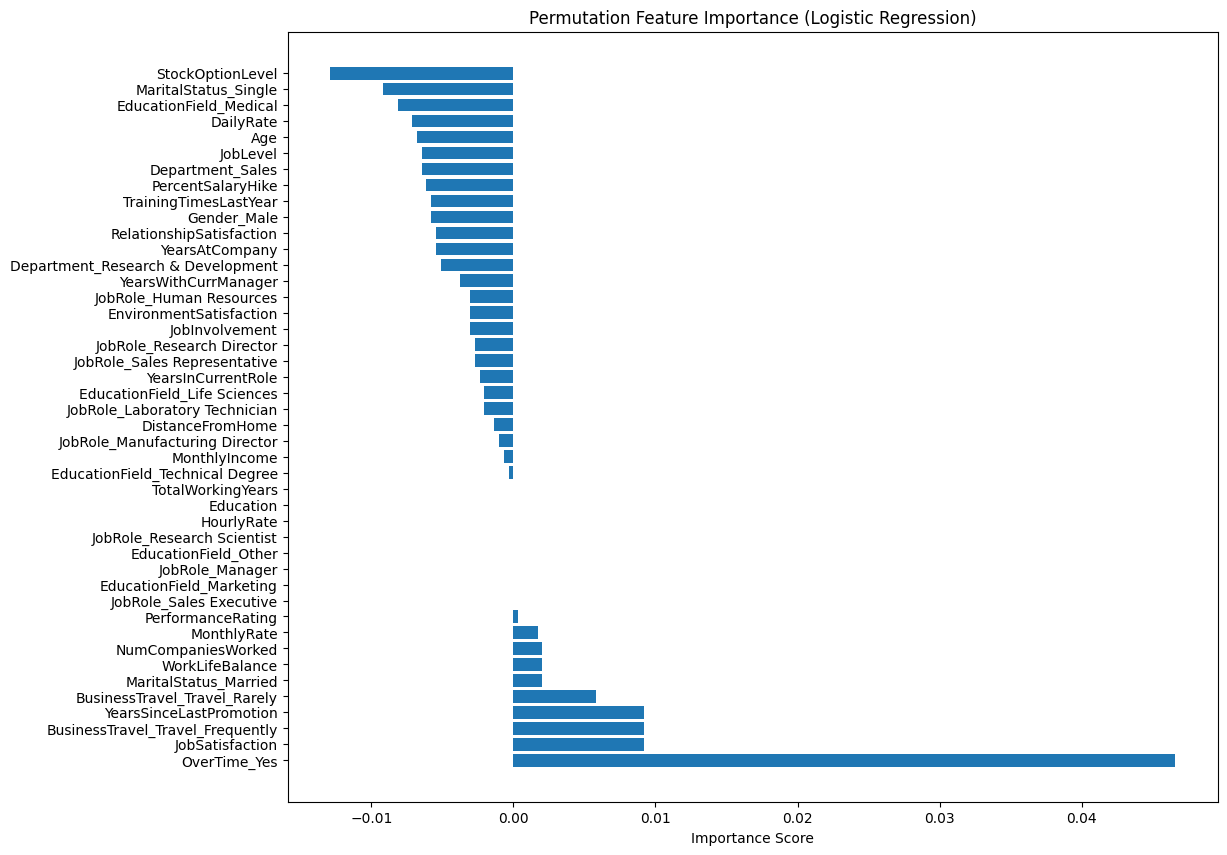

In [50]:
# Plot
plt.figure(figsize=(12, 10))
plt.barh(perm_df["Feature"], perm_df["Importance"])
plt.title("Permutation Feature Importance (Logistic Regression)")
plt.xlabel("Importance Score")
plt.show()

You should see a horizontal bar chart with feature names on the y-axis and their importance scores on the x-axis. The higher the score, the more 

* High importance: Features like "OverTime_Yes" or "JobSatisfaction" may appear at the top, meaning shuffling them hurts model accuracy the most.
* Low importance: Features with small or near-zero scores do not contribute significantly to the predictions and might be redundant.

What If Some Permutation Importance Values Are Negative?
* Negative values in permutation importance can occur, and they indicate that shuffling a particular feature actually improved the model's performance instead of degrading it. This could mean the feature isn't relevant or could correlated with other features.


## Task Group 5 - Random Forest Classifier and Feature Importance

### Task 13
Train a Random Forest Classifier
* Train a random forest classifier with `n_estimators=100` and `random_state=42.`

In [51]:
# Train Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

### Task 14
Extract Feature Importance 
* Extract the feature importances from the random forest model
* Store the feature importance values in a pandas Series and sort them in ascending order for better visualization.

In [52]:
# Extract feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)


### Task 15
Plot Feature Importance Using a Bar Chart
* Plot the feature importance as a horizontal bar chart with feature names and importance values as the heights.

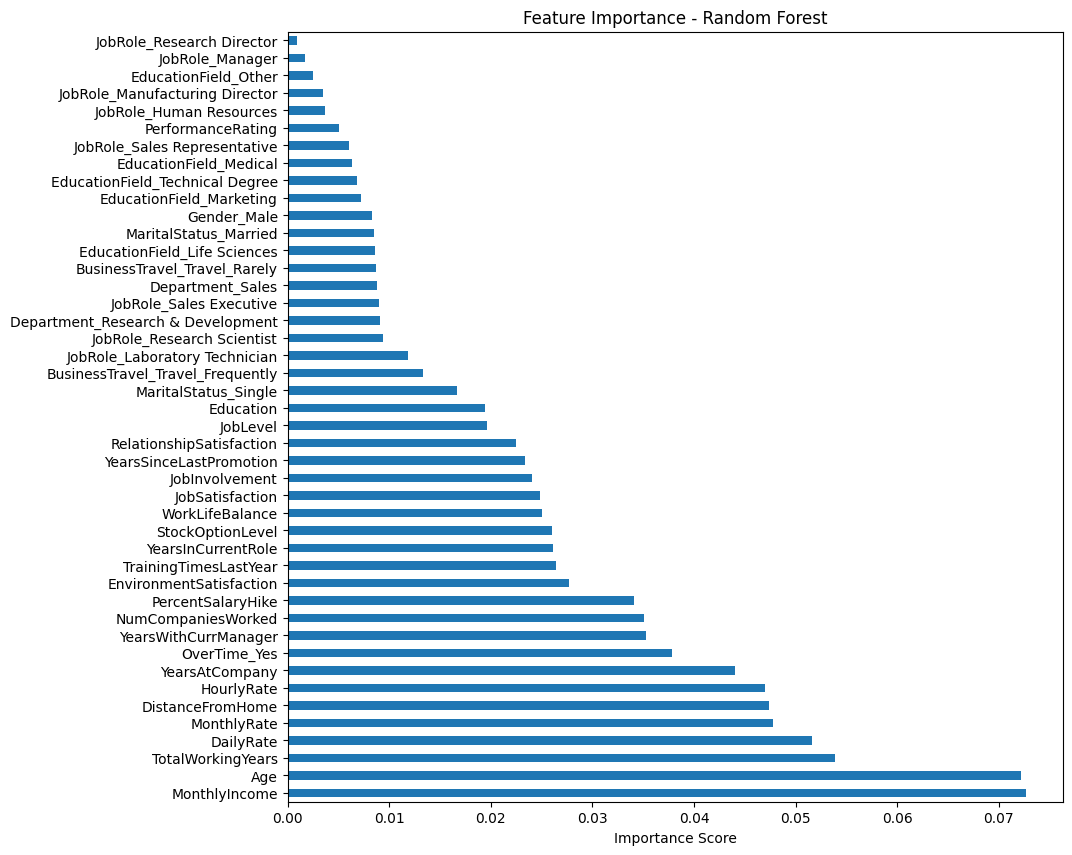

In [53]:
# Plot feature importance
plt.figure(figsize=(10, 10))
feature_importances.plot(kind="barh")
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.show()

The features at the top of the chart have the highest importance, meaning they play a crucial role in predicting attrition.  How many of these were top of the logistic regression model coefficents?  Each model is different, so the importance will not match exactly.

## Task Group 6 - Partial Dependence Plots (PDP) and Individual Conditional Expectation (ICE)

### Task 16
Select Top 3 Features from the Random Forest model
* Select the top three features based on the random forest model feature importances

In [54]:
# Select top 3 most important features
top_3_features = feature_importances.head(3).index
print("Top 3 Features for PDP and ICE:", top_3_features)

Top 3 Features for PDP and ICE: Index(['MonthlyIncome', 'Age', 'TotalWorkingYears'], dtype='object')


### Task 17
Generate Partial Dependence Plots (PDP)
* Create PDP plots for the top three features using the random forest model and `X_train_scaled`

Text(0.5, 1.0, 'PDP Plot for top three features')

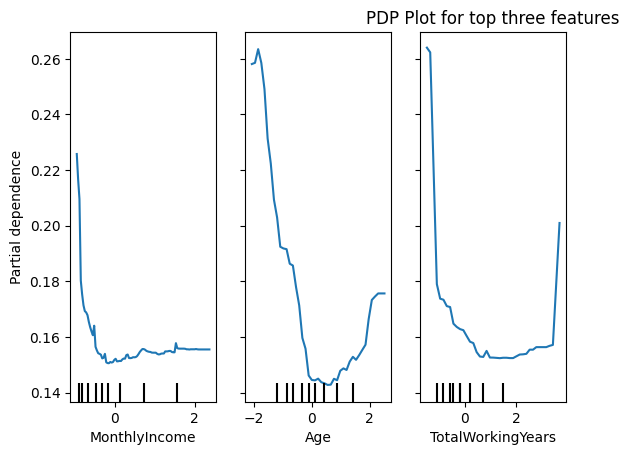

In [55]:
#Create PDP plot
PartialDependenceDisplay.from_estimator(
    rf, 
    X_train_scaled, 
    top_3_features,
    kind='average',  # Shows individual lines
    centered=False,      # Centers the lines at a reference point
)
plt.title("PDP Plot for top three features")

The PDPs show some interesting trends -- the y-axis here is in probability, as the model is a classifier. For `MonthlyIncome,` low values are associated with a higher likelihood of attrition. `Age` has a bimodal effect -- low values have the highest likelihood of attrition, drop for middle ages, and then increase for higher ages. You can also see this with `TotalWorkingYears.` Both young workers and older workers are more likely to attrite; younger workers are probably looking for another opportunity while older workers may be retiring.  

### Task 18
Generate Combined PDP/ICE Plots for the Top 3 Features
* Create Combined ICE/PDP plots for the top three features using the random forest model and `X_train_scaled`

Text(0.5, 1.0, 'PDP/ICE Plot for top three features')

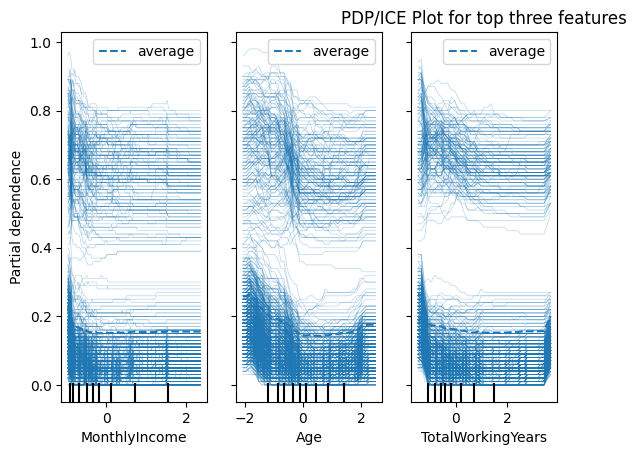

In [56]:
#Create combined PDP/ICE plot
PartialDependenceDisplay.from_estimator(
    rf, 
    X_train_scaled, 
    top_3_features,
    kind='both',  
    centered=False,      # Centers the lines at a reference point
)
plt.title("PDP/ICE Plot for top three features")

The combined ICE/PDP plots highlight the variation in the dataset. The y-axis shows quite a range of values.  
The thin blue lines show how each individual employee's prediction changes as the feature is varied, and the thick, dotted, orange line represents the average effect. Since the blue lines are not parallel and vary, the features affect different employees differently (possible interactions with other features).


### Task 19
Generate a 2D Partial Dependence Plot
* Create 2D PDP plot using the top _two_features from the random forest feature importances

Text(0.5, 1.0, '2D PDP Plot for top two features')

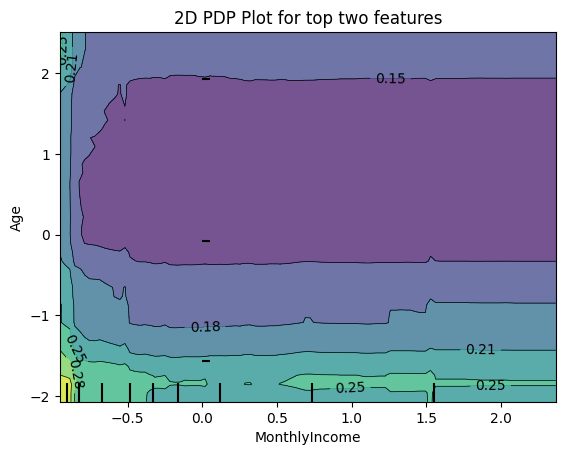

In [57]:
# Create2D PDP plot for interaction between two features
top_2_features = top_3_features[:2]  # First two of the top 3 features
PartialDependenceDisplay.from_estimator(
    rf, 
    X_train_scaled, 
    [(top_2_features[0], top_2_features[1])],
    kind='average',  
    centered=False,      # Centers the lines at a reference point
)
plt.title("2D PDP Plot for top two features")

The 2D PDP plot generates a color-coded contour plot that shows how attrition probability changes when both `Age` and `MonthlyIncome` are varied together. 2D PDP plots reveal interactions between two features that a 1D plot might miss. For example, you saw that `Age` had a bimodal PDP plot—low and high age values had the highest attrition probabilities. The 2D plot shows that the areas of highest attrition (labeled 0.24 and light green) correspond to low ages but are split between low and high monthly incomes. So young people with middle incomes are less likely to leave than young people with high or low salary ranges. For very high ages, low monthly incomes are associated with a higher attrition likelihood.